### Spectroscopic Data Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [17]:
import os, re
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as mp
import scipy.interpolate as si
import scipy.signal as ss
import spec_funcs as sf
from scipy.fftpack import rfft, irfft, fftfreq
from statistics import mean

##### Set-up script
###### Selcet input folder and polarisation

In [18]:
# change to gui at later date
# polarisations as written in file names
polarisations = ["143", "188"]

# folder containing all the requisite subfolders and data - refrences included
path = "C:\\Users\\sk88\\Desktop\\New Folder"

# choose to focus on a particular wavelength range
zoom = 1
lower = 550
upper = 650

# used to convert raw data to nm (future)
converter = 1

# save images (1 for save)
save_fig = 0

# initialise lists
file_list = []
folder_list = []
bg_wavelengths = []
bg_Is = []
wave_sets = []
I_sets= []
I_0 = []
freq = []
OD = []
starts = []
stops = []

##### Import Raw Spectroscopy Data

###### Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


In [19]:
# holder removes first folder from lists so only actual data is used
holder = 0
# walk through directory and extract all relevant files
for root, dirs, files in os.walk(path):
    if holder == 1:
        folder_list.append(root)
        temp =[]
        for file in files:
            if(file.endswith((".csv", ".txt"))):
                # ignore collection data notes
                if "notes" in file or "setup" in file:
                    continue
                else:
                    temp.append(file)
        file_list.append(temp)
    else:
        holder = 1

'''
filter through files and seperate transmission data into groups:
polarisation > references > separators eg. temperature > transmission sets
'''
for polarisation in polarisations:
    wavelengths = []
    Is = []
    for index, folder in enumerate(folder_list):
        for file in file_list[index]:
            dataset = os.path.join(folder, file)
            if polarisation in dataset:
                # check for reference data
                # add flag if no reference!
                if "ref" in dataset or "reference" in dataset:
                    bg_temp_wave = []
                    bg_temp_I = []
                    with open(dataset, 'r', newline='') as raw_file:
                        for row in raw_file:
                            if sf.check_str(row) == True:
                                temp = re.split('\t|,|;', row)
                                bg_temp_wave.append(float(temp[0]))
                                bg_temp_I.append(float(temp[1]))
                        raw_file.close()
                    bg_wavelengths.append(bg_temp_wave)
                    bg_Is.append(bg_temp_I)
                else:
                    temp_wave = []
                    temp_I =[]
                    with open(dataset, 'r', newline='') as raw_file:
                        for row in raw_file:
                            if sf.check_str(row) == True:
                                temp = re.split('\t|,|;', row)
                                temp_wave.append(float(temp[0]))
                                temp_I.append(float(temp[1]))
                        raw_file.close()
                    wavelengths.append(temp_wave)
                    Is.append(temp_I)
    wave_sets.append(wavelengths)
    I_sets.append(Is)

#####  Calculate OD

###### Generate interplolated background data to match raw absorption data length and then calculate Optical Depth

In [20]:
'''
interpolate reference data for each file - avoids issue of wavelength array length mismatch

'''
check_temp = []
# cycle through polarisations
for idx_1 in range(len(polarisations)):
    temp_I_0 = []
    temp_OD = []
    I_temp = []
    # generate spline co-effs
    spline_coeffs = si.splrep(bg_wavelengths[idx_1], bg_Is[idx_1])
    # calculate referenece for each wavelength subset
    for idx_2, wavelength in enumerate(wave_sets[idx_1]):
        spline_temp = (si.splev(wavelength, spline_coeffs))
        I_temp = I_sets[idx_1][idx_2]
        # scale data to remove negative values
        if np.nanmin(spline_temp) < 0 or np.nanmin(I_temp) < 0:
            if np.nanmin(spline_temp) < np.nanmin(I_temp):
                adjust = np.nanmin(spline_temp)
            elif np.nanmin(I_temp) < np.nanmin(spline_temp):
                adjust = np.nanmin(I_temp)
            temp_I_0.append(spline_temp - adjust)
            I_temp -= adjust
        else:
            temp_I_0.append(spline_temp)
        temp_OD.append(np.log(13*temp_I_0[idx_2]/I_temp))
    check_temp.append(I_temp)
    I_0.append(temp_I_0)
    OD.append(temp_OD)

# zoom function for wavelength range
if zoom == 1:
    for index, waves in enumerate(wave_sets):
        start = []
        stop = []
        for wave in waves:
            for idx, value in enumerate(wave):
                if value <= lower:
                    temp_start = idx
                if value <= upper:
                    temp_stop = idx
            start.append(temp_start)
            stop.append(temp_stop)
        starts.append(start)
        stops.append(stop)
elif zoom != 1:
    for index, waves in enumerate(wave_sets):
        start = []
        stop = []
        for wave in waves:
            start.append(0)
            stop.append(-1)
        starts.append(start)
        stops.append(stop)

# mask OD data to remove -inf, nan and inf from normalisation
masked_OD = ma.masked_invalid(OD)
# normalise the OD
OD_norm = masked_OD / np.nanmax(masked_OD)


c:\Users\sk88\Documents\Python\Spectroscopy\.spect_venv\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\sk88\Documents\Python\Spectroscopy\.spect_venv\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


##### Print Raw Output

###### Plot individual spectroscopy data

IndexError: list index out of range

c:\Users\sk88\Documents\Python\Spectroscopy\.spect_venv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


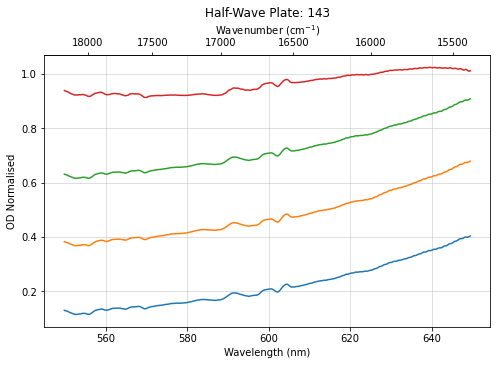

In [21]:
if zoom == 0:
    string_format = path + '\\' + str(round(min(bg_wavelengths[0]))) + '_' + str(round(max(bg_wavelengths[0]))) + '_'
else:
    string_format = path + '\\' + str(lower) + '_' + str(upper) + '_'

# create separate plots for each polarisation
for idx_1, polarisation in enumerate(polarisations):
    
    fig_1, ax_1 = mp.subplots(figsize=(8, 5))
    ax_1.set_title(str('Half-Wave Plate: ' + str(polarisation)))
    ax_1.set(xlabel='Wavelength (nm)', ylabel='OD Normalised')
    sec_ax = ax_1.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))
    sec_ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_1.grid(True)
    ax_1.grid(True, color='silver', linewidth=0.5)

    
    #shift each spectrum by a defined value
    shift = 0
    for idx_2, wave in enumerate(wave_sets[index]):
        lbl = os.path.split(folder_list[idx_2])
        data = OD_norm[idx_1][idx_2] + shift
        ax_1.plot(wave[start[idx_2]:stop[idx_2]], data[start[idx_2]:stop[idx_2]], color=None, marker=None, linestyle='-', alpha=1, label=lbl[1])

        shift += (0.25)
    
    ax_1.legend(loc='upper left', fontsize=8)

    if save_fig == 1:
        fig_1.savefig(fname=string_format + str(polarisation) + '.jpg', dpi='figure', format='jpg', bbox_inches='tight')

##### Find Peaks

###### Find peak locations, extract central wavelength / energy, linewidth and determine if Gaussian or Lorentzian.

In [ ]:
data = OD_norm[1][2]
wl = wave[start[0]:stop[0]]

c = 2.99792458E8

N = np.size(data)
time = [(x * 1E-9)/c for x in wl]
T = time[1] - time[0]
data_fft = rfft(data)
data_freq = fftfreq(N,T)

peak_thresh =  0.006 * np.max(data_fft)
peaks, _ = ss.find_peaks(data_fft[:N//2], prominence=peak_thresh)

background = mean(data[start[0]:stop[0]])

data_filter = data_fft.copy()

data_filter[350:360] = 0

filtered_data = irfft(data_filter)
fig, ax = mp.subplots()
ax.plot(data_freq[:N//2], data_fft[:N//2])
ax.plot(data_freq[:N//2], data_filter[:N//2])
mp.ylim([0, 10])
fig, ax = mp.subplots()
ax.plot(wl, filtered_data[start[0]:stop[0]], 'r')
fig_2, ax_2 = mp.subplots()
ax_2.plot(wl, data[start[0]:stop[0]], 'b')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
data = OD_norm[1][0]
wl = wave[start[0]:stop[0]]

c = 2.998E8

N = np.size(data)
time = [(x * 1E-9)/c for x in wl]
T = time[1] - time[0]
data_fft = rfft(data)
data_freq = fftfreq(N,T)

peak_thresh =  0.006 * np.max(data_fft)
peaks, _ = ss.find_peaks(data_fft[:N//2], prominence=peak_thresh)

background = mean(data[start[0]:stop[0]])

data_filter = data_fft.copy()

data_filter[350:360] = 0

filtered_data = irfft(data_filter)
fig, ax = mp.subplots()
ax.plot(data_freq[:N//2], data_fft[:N//2])
ax.plot(data_freq[:N//2], data_filter[:N//2])
mp.ylim([0, 10])
fig, ax = mp.subplots()
ax.plot(wl, filtered_data[start[0]:stop[0]], 'r')
fig_2, ax_2 = mp.subplots()
ax_2.plot(wl, data[start[0]:stop[0]], 'b')